In [ ]:


import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohansakib75/sartaj-brain")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sartaj-brain


In [ ]:
import os
import kagglehub

# Download dataset
path = kagglehub.dataset_download("sohansakib75/sartaj-brain")

print("Dataset root path:", path)

# List folders and files inside
print("Contents inside dataset folder:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📂 {item}/")
    else:
        print(f"📄 {item}")


Dataset root path: /kaggle/input/sartaj-brain
Contents inside dataset folder:
📂 Brain Sartaj/


glioma_tumor: 926 images
meningioma_tumor: 937 images
no_tumor: 500 images
pituitary_tumor: 901 images


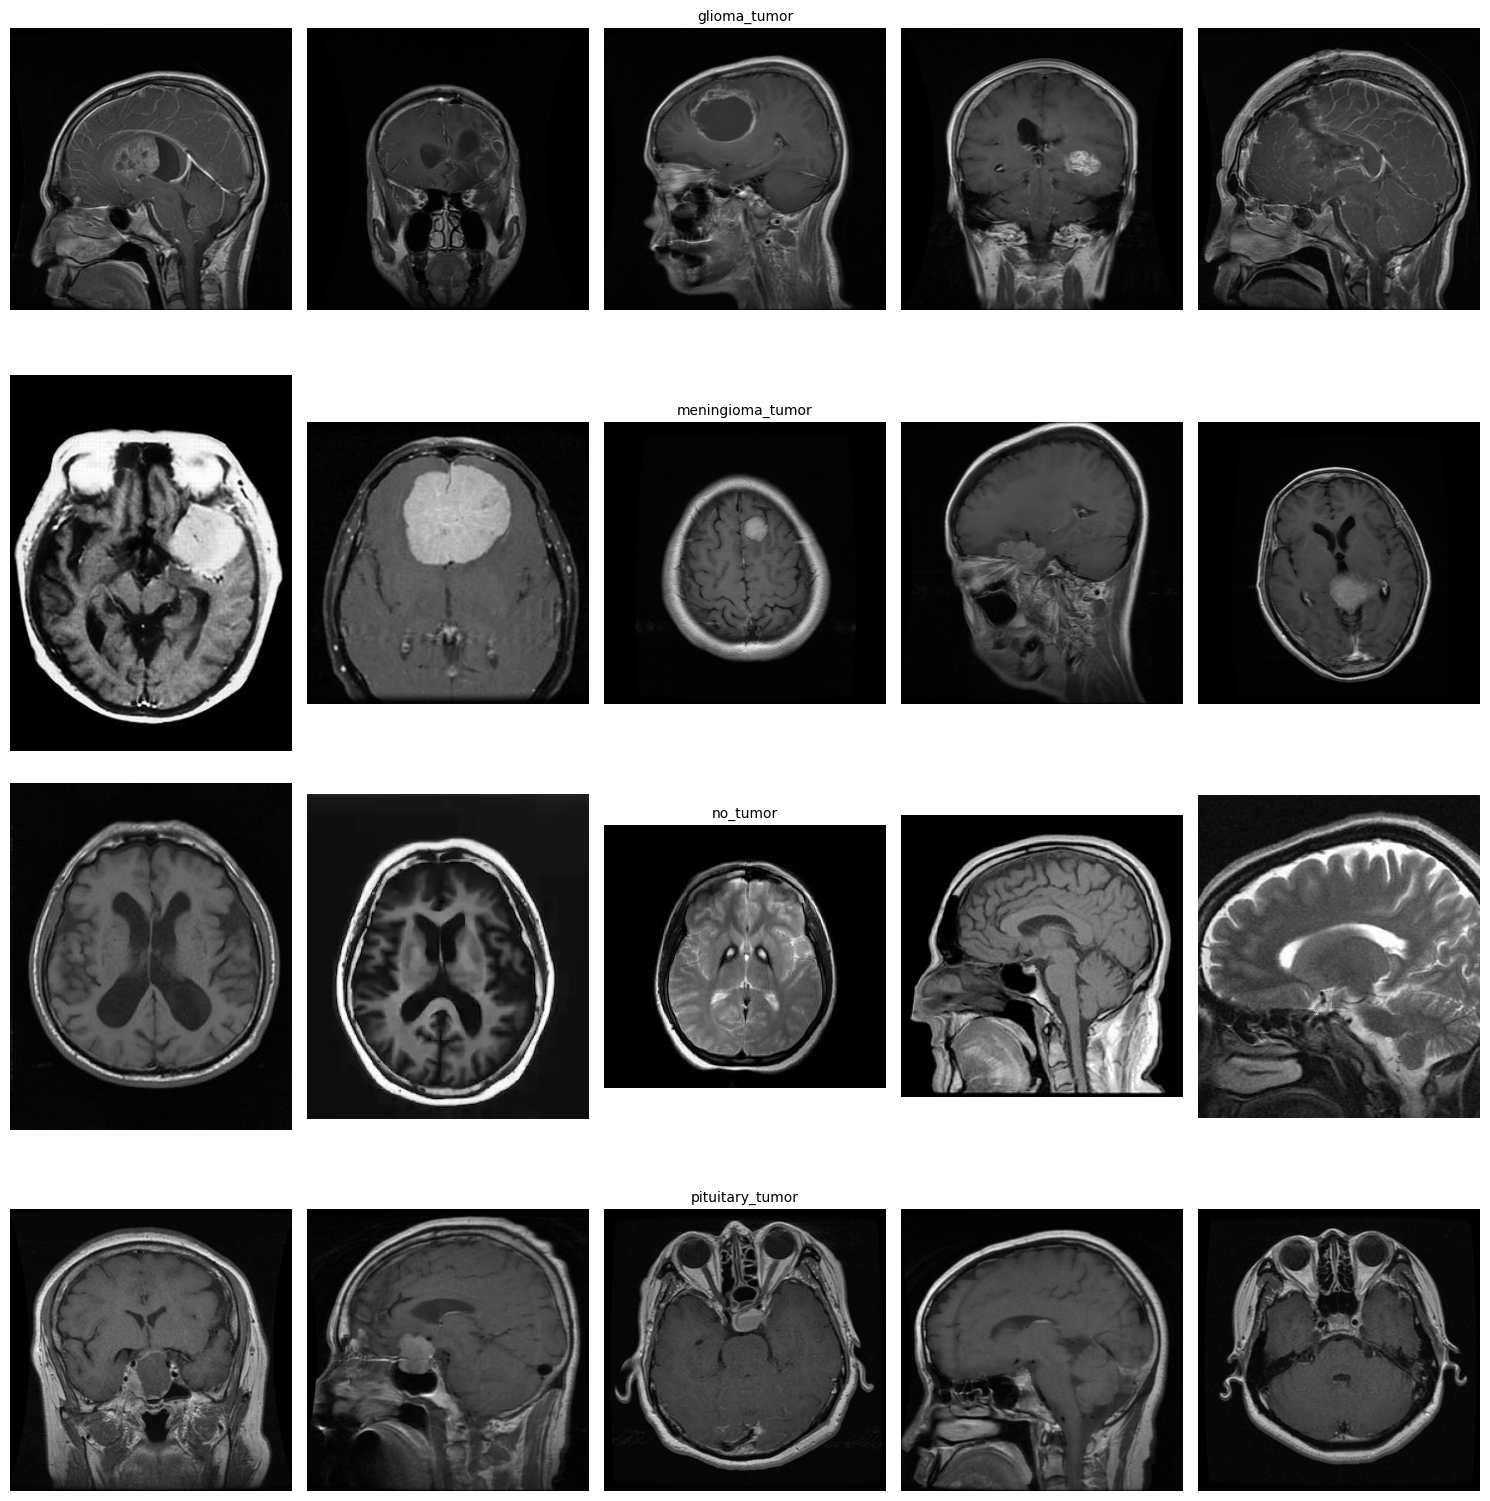

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import random

dataset_path = "/kaggle/input/sartaj-brain/Brain Sartaj"

# Get all classes
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])


for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    img_count = len(glob.glob(os.path.join(cls_path, "*.jpg")) +
                    glob.glob(os.path.join(cls_path, "*.jpeg")) +
                    glob.glob(os.path.join(cls_path, "*.png")))
    print(f"{cls}: {img_count} images")


fig, axes = plt.subplots(len(classes), 5, figsize=(15, 4 * len(classes)))

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    image_files = glob.glob(os.path.join(cls_path, "*.jpg")) + \
                  glob.glob(os.path.join(cls_path, "*.jpeg")) + \
                  glob.glob(os.path.join(cls_path, "*.png"))

    if len(image_files) == 0:
        continue

    # If fewer than 5 images exist
    sample_files = random.sample(image_files, min(5, len(image_files)))

    for j in range(5):
        ax = axes[i, j] if len(classes) > 1 else axes[j]
        if j < len(sample_files):
            img = plt.imread(sample_files[j])
            ax.imshow(img)
        ax.axis("off")
        if j == 2:
            ax.set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()



Processing class: glioma_tumor (926 images)


glioma_tumor Progress: 100%|█████████████████████████████████████| 926/926 [00:05<00:00, 167.18it/s]



Processing class: meningioma_tumor (937 images)


meningioma_tumor Progress: 100%|█████████████████████████████████| 937/937 [00:05<00:00, 159.81it/s]



Processing class: no_tumor (500 images)


no_tumor Progress: 100%|█████████████████████████████████████████| 500/500 [00:02<00:00, 179.11it/s]



Processing class: pituitary_tumor (901 images)


pituitary_tumor Progress: 100%|██████████████████████████████████| 901/901 [00:05<00:00, 162.27it/s]


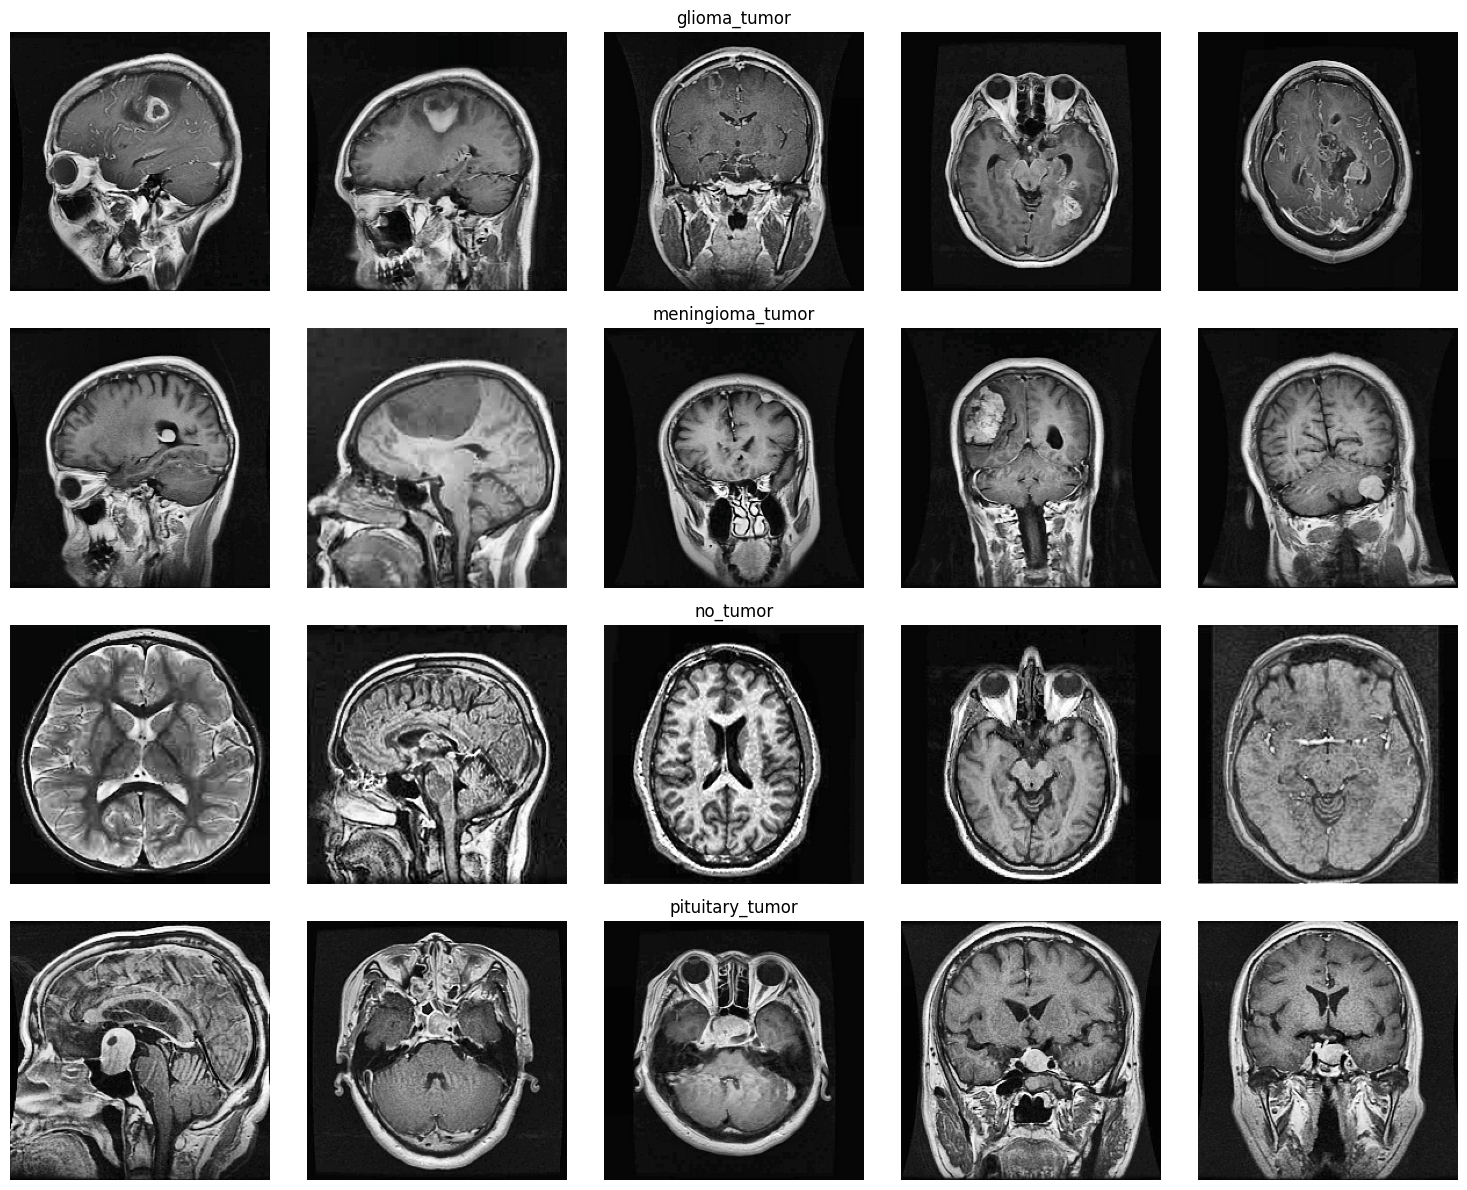


✅ Preprocessed images saved in: /kaggle/working/preprocessed_dataset_no_mask


In [ ]:
import os
import cv2
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Paths
input_dir = "/kaggle/input/sartaj-brain/Brain Sartaj"
output_dir = "/kaggle/working/preprocessed_dataset_no_mask"
os.makedirs(output_dir, exist_ok=True)

img_size = (224, 224)
num_samples = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

# Gaussian filter (GPU)
def gaussian_filter_gpu(img_tensor, kernel_size=5, sigma=1.0):
    C,H,W = img_tensor.shape
    x = torch.arange(kernel_size, dtype=torch.float32, device=img_tensor.device) - kernel_size//2
    gauss = torch.exp(-(x**2)/(2*sigma**2))
    gauss = gauss / gauss.sum()
    gauss_2d = gauss[:, None] @ gauss[None, :]
    gauss_2d = gauss_2d.expand(C,1,kernel_size,kernel_size)
    img_tensor = img_tensor.unsqueeze(0)
    img_filtered = F.conv2d(img_tensor, gauss_2d, padding=kernel_size//2, groups=C)
    return img_filtered[0]

# Classes
classes = sorted([d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))])

fig, axes = plt.subplots(len(classes), num_samples, figsize=(15,3*len(classes)))

for i, cls in enumerate(classes):
    cls_path = os.path.join(input_dir, cls)
    save_cls_path = os.path.join(output_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".png",".jpeg"))]
    sample_files = random.sample(files, min(num_samples,len(files)))

    print(f"\nProcessing class: {cls} ({len(files)} images)")
    for file in tqdm(files, desc=f"{cls} Progress", ncols=100):
        img_path = os.path.join(cls_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # 1️⃣ Resize
        img_resized = cv2.resize(img, img_size)

        # 2️⃣ CLAHE on L channel
        lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe,a,b))
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

        # 3️⃣ Convert to tensor [C,H,W] in 0-1
        img_tensor = torch.from_numpy(img_clahe.transpose(2,0,1)).float().to(device)/255.0

        # 4️⃣ Gaussian smoothing
        img_blur = gaussian_filter_gpu(img_tensor, kernel_size=5, sigma=1.0)

        # 5️⃣ Sharpening (Unsharp mask)
        img_sharp = torch.clamp(1.5*img_tensor - 0.5*img_blur,0,1)

        # 6️⃣ Contrast Stretching
        min_val = img_sharp.min()
        max_val = img_sharp.max()
        img_contrast = (img_sharp - min_val)/(max_val - min_val + 1e-8)  # avoid div by zero

        # 7️⃣ Save image back to CPU
        img_final = (img_contrast.cpu().numpy()*255).astype(np.uint8).transpose(1,2,0)
        cv2.imwrite(os.path.join(save_cls_path, file), img_final)

        # Plot sample images
        if file in sample_files:
            ax = axes[i,sample_files.index(file)]
            ax.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
            ax.axis("off")
            if sample_files.index(file) == num_samples//2:
                ax.set_title(cls, fontsize=12)

plt.tight_layout()
plt.show()
print("\n✅ Preprocessed images saved in:", output_dir)


In [ ]:
import os
import shutil
import random

# Preprocessed dataset path
preprocessed_dir = "/kaggle/working/preprocessed_dataset_no_mask"

# Split paths
split_base = "/kaggle/working/brain_split"
train_dir = os.path.join(split_base, "train")
val_dir   = os.path.join(split_base, "val")
test_dir  = os.path.join(split_base, "test")

# Create split folders
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

classes = sorted(os.listdir(preprocessed_dir))

for cls in classes:
    cls_path = os.path.join(preprocessed_dir, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(files)

    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    splits = {
        train_dir: files[:n_train],
        val_dir: files[n_train:n_train+n_val],
        test_dir: files[n_train+n_val:]
    }

    for split_folder, split_files in splits.items():
        cls_split_path = os.path.join(split_folder, cls)
        os.makedirs(cls_split_path, exist_ok=True)
        for f in split_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(cls_split_path, f))

print("✅ Dataset split into 75-10-15 and saved in:", split_base)


✅ Dataset split into 75-10-15 and saved in: /kaggle/working/brain_split


In [ ]:
import os

split_base = "/kaggle/working/brain_split"
splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(split_base, split)
    print(f"\n📂 {split.capitalize()} Split:")
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        print(f"{cls}: {num_images} images")



📂 Train Split:
glioma_tumor: 877 images
meningioma_tumor: 863 images
no_tumor: 463 images
pituitary_tumor: 854 images

📂 Val Split:
glioma_tumor: 176 images
meningioma_tumor: 169 images
no_tumor: 91 images
pituitary_tumor: 168 images

📂 Test Split:
glioma_tumor: 260 images
meningioma_tumor: 253 images
no_tumor: 141 images
pituitary_tumor: 261 images


In [ ]:
import os
import cv2
import numpy as np
import random

train_dir = "/kaggle/working/brain_split/train"
aug_train_dir = "/kaggle/working/brain_train_aug"
os.makedirs(aug_train_dir, exist_ok=True)

# =========================
# Augmentation functions
# =========================
def random_flip(img):
    flip_code = random.choice([-1, 0, 1])
    return cv2.flip(img, flip_code)

def random_rotate(img):
    angle = random.uniform(-25, 25)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 2)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_zoom(img):
    zoom_factor = random.uniform(0.8, 1.2)
    h, w = img.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    img_resized = cv2.resize(img, (new_w, new_h))
    if zoom_factor < 1:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        img_padded = cv2.copyMakeBorder(
            img_resized, pad_h, h - new_h - pad_h,
            pad_w, w - new_w - pad_w, cv2.BORDER_REFLECT
        )
        return img_padded
    else:
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return img_resized[start_h:start_h + h, start_w:start_w + w]

def random_brightness(img):
    factor = random.uniform(0.7, 1.3)
    img = img.astype(np.float32) * factor
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

augmentations = [random_flip, random_rotate, random_zoom, random_brightness]

# =========================
# Apply augmentations (2 augmentations per image)
# =========================
classes = sorted(os.listdir(train_dir))
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    save_cls_path = os.path.join(aug_train_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    for file in os.listdir(cls_path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(cls_path, file)
        img = cv2.imread(img_path)

        # Save original image
        cv2.imwrite(os.path.join(save_cls_path, file), img)

        # Apply TWO random augmentations
        aug_funcs = random.sample(augmentations, 2)
        aug_img = img.copy()

        for i, aug_func in enumerate(aug_funcs):
            aug_img = aug_func(aug_img)
            filename, ext = os.path.splitext(file)
            aug_name = f"{filename}_aug{i+1}{ext}"
            cv2.imwrite(os.path.join(save_cls_path, aug_name), aug_img)

# =========================
# Print image count per class
# =========================
print("\n📊 Image count per class after augmentation:")
for cls in classes:
    cls_path = os.path.join(aug_train_dir, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    print(f"{cls}: {count} images")

print(f"\n✅ All train images and two augmented versions per image saved in: {aug_train_dir}")



📊 Image count per class after augmentation:
glioma_tumor: 2631 images
meningioma_tumor: 2589 images
no_tumor: 1389 images
pituitary_tumor: 2562 images

✅ All train images and two augmented versions per image saved in: /kaggle/working/brain_train_aug


**deit tiny**

****

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/35 | Train Loss: 0.3837, Acc: 0.8579 | Val Loss: 0.1261, Acc: 0.9569
Epoch 2/35 | Train Loss: 0.1134, Acc: 0.9620 | Val Loss: 0.0958, Acc: 0.9754
Epoch 3/35 | Train Loss: 0.0689, Acc: 0.9764 | Val Loss: 0.1328, Acc: 0.9508
Epoch 4/35 | Train Loss: 0.0329, Acc: 0.9888 | Val Loss: 0.1205, Acc: 0.9569
Epoch 5/35 | Train Loss: 0.0485, Acc: 0.9838 | Val Loss: 0.1131, Acc: 0.9600
Epoch 6/35 | Train Loss: 0.0418, Acc: 0.9873 | Val Loss: 0.1058, Acc: 0.9569
Epoch 7/35 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.2285, Acc: 0.9231
Early stopping triggered

✅ Training complete. Total time: 195.61s

📄 Train Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor     0.9956    0.9856    0.9906      2082
meningioma_tumor     0.9835    0.9910    0.9872      2106
        no_tumor     0.9947    0.9947    0.9947      1125
 pituitary_tumor     0.9921    0.9946    0.9933      2025

        accuracy                         0.9910      7338
       macro

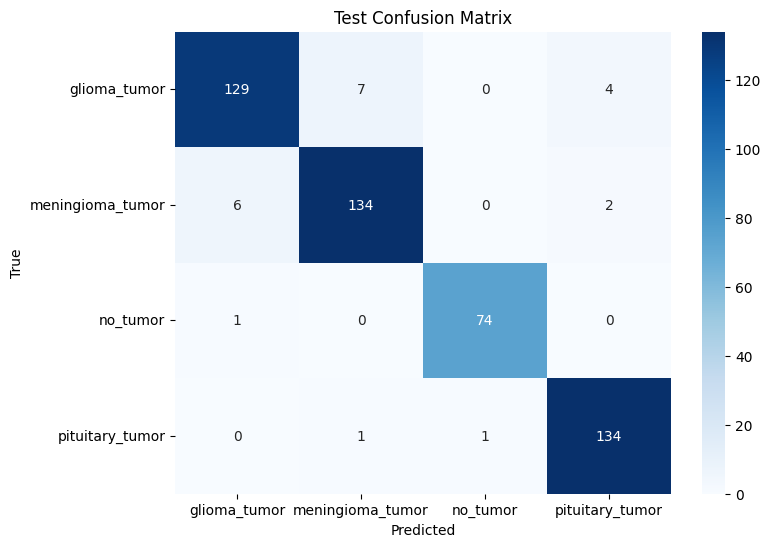


📊 Class-wise ROC AUC & PR AUC (Test):
              Class ROC AUC  PR AUC
0      glioma_tumor  0.9944  0.9891
1  meningioma_tumor  0.9938  0.9854
2          no_tumor  0.9999  0.9997
3   pituitary_tumor  0.9981  0.9944
Inference time: 0.98s | Per sample: 0.0020s | GPU Mem: 105.82MB | RAM: 2381.00MB

Cohen's Kappa: 0.9395
Brier Score (avg per class): 0.0154
Accuracy 95% CI: [0.9351,0.9736]
T-test class0 vs class1: stat=-0.7828, p=0.4339
Mean PPV: 0.9590 | Mean NPV: 0.9846
Mean Specificity: 0.9845


In [ ]:
import os, time, psutil
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, brier_score_loss
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import timm

# ----------------------
# 0️⃣ Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# 1️⃣ Dataset & Loader
# ----------------------
batch_size = 32
train_dir = "/kaggle/working/brain_train_aug"
val_dir   = "/kaggle/working/brain_split/val"
test_dir  = "/kaggle/working/brain_split/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# ----------------------
# 2️⃣ Model (DeiT Tiny)
# ----------------------
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# ----------------------
# 3️⃣ Training Loop
# ----------------------
num_epochs = 35
best_val_loss = float('inf')
patience_counter = 0
train_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_deit.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered")
            break

train_time = time.time() - train_start_time
print(f"\n✅ Training complete. Total time: {train_time:.2f}s")

# ----------------------
# 4️⃣ Load best model
# ----------------------
model.load_state_dict(torch.load('best_deit.pth'))
model.eval()

# ----------------------
# 5️⃣ Prediction helper
# ----------------------
def get_preds(loader):
    labels_list, preds_list, probs_list = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
    return np.array(labels_list), np.array(preds_list), np.array(probs_list)

train_labels, train_preds, train_probs = get_preds(train_loader)
val_labels, val_preds, val_probs       = get_preds(val_loader)
test_labels, test_preds, test_probs    = get_preds(test_loader)
test_labels_onehot = np.eye(num_classes)[test_labels]

# ----------------------
# 6️⃣ Classification Reports
# ----------------------
print("\n📄 Train Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names, digits=4))
print("\n📄 Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))
print("\n📄 Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# ----------------------
# 7️⃣ Confusion Matrix
# ----------------------
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()

# ----------------------
# 8️⃣ ROC & PR AUC
# ----------------------
roc_auc_list = [roc_auc_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
pr_auc_list  = [average_precision_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
auc_df = pd.DataFrame({"Class": class_names, "ROC AUC": [f"{x:.4f}" for x in roc_auc_list],
                       "PR AUC": [f"{x:.4f}" for x in pr_auc_list]})
print("\n📊 Class-wise ROC AUC & PR AUC (Test):")
print(auc_df)

# ----------------------
# 9️⃣ Inference time & memory
# ----------------------
start_inf = time.time(); _ = get_preds(test_loader)
inf_time = time.time()-start_inf
inf_time_per_sample = inf_time / len(test_dataset)
mem_usage = torch.cuda.memory_allocated()/1024**2 if torch.cuda.is_available() else 0
ram_usage = psutil.virtual_memory().used/1024**2
print(f"Inference time: {inf_time:.2f}s | Per sample: {inf_time_per_sample:.4f}s | GPU Mem: {mem_usage:.2f}MB | RAM: {ram_usage:.2f}MB")

# ----------------------
# 🔟 Additional metrics
# ----------------------
kappa = cohen_kappa_score(test_labels, test_preds)
brier_list = [brier_score_loss(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
brier_avg = np.mean(brier_list)

# Bootstrap accuracy CI
n_samples = len(test_labels)
boot_acc = []
rng = np.random.default_rng()
for _ in range(1000):
    idx = rng.choice(n_samples, n_samples, replace=True)
    boot_acc.append(np.mean(test_labels[idx] == test_preds[idx]))
ci_low, ci_high = np.percentile(boot_acc, [2.5,97.5])

# Compute PPV, NPV, Specificity for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-8)
NPV = TN / (TN + FN + 1e-8)
specificity = TN / (TN + FP + 1e-8)

mean_ppv = np.mean(PPV)
mean_npv = np.mean(NPV)
mean_specificity = np.mean(specificity)

# T-test for the first two classes
ttest_res = ttest_ind(test_probs[:, 0], test_probs[:, 1])

# Print metrics
print(f"\nCohen's Kappa: {kappa:.4f}")
print(f"Brier Score (avg per class): {brier_avg:.4f}")
print(f"Accuracy 95% CI: [{ci_low:.4f},{ci_high:.4f}]")
print(f"T-test class0 vs class1: stat={ttest_res.statistic:.4f}, p={ttest_res.pvalue:.4f}")
print(f"Mean PPV: {mean_ppv:.4f} | Mean NPV: {mean_npv:.4f}")
print(f"Mean Specificity: {mean_specificity:.4f}")


In [ ]:

!pip install torchsummary

# =========================
# Imports
# =========================
import torch
import torch.optim as optim
from torchsummary import summary
import timm

# =========================
# Device Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# Model Setup (DeiT-Small)
# =========================
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=5)
model.to(device)

# =========================
# Model Summary
# =========================
print("✅ DeiT-Small Model Summary\n")
summary(model, input_size=(3, 224, 224), device=str(device))

# =========================
# Count trainable & non-trainable params
# =========================
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total_params = trainable_params + non_trainable_params

print("\n================ Parameters Info ================")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {total_params:,}")

# =========================
# Optimizer Setup
# =========================
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

print("\n================ Optimizer Info ================")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Weight Decay: {optimizer.param_groups[0]['weight_decay']}")

# =========================
# Model Size
# =========================
import os
import torch
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024**2  # in MB (assuming 4 bytes per parameter)
print(f"\nModel size: {model_size:.2f} MB")


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ DeiT-Small Model Summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
          Identity-5             [-1, 197, 384]               0
          Identity-6             [-1, 197, 384]               0
         LayerNorm-7             [-1, 197, 384]             768
            Linear-8            [-1, 197, 1152]         443,520
          Identity-9           [-1, 6, 197, 64]               0
         Identity-10           [-1, 6, 197, 64]               0
         Identity-11             [-1, 197, 384]               0
           Linear-12             [-1, 197, 384]         147,840
          Dropout-13             [-1, 197, 384]               0
        Att

**tinyvit **

model.safetensors:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Epoch 1/35 | Train Loss: 0.5655, Acc: 0.8057 | Val Loss: 0.2761, Acc: 0.8831
Epoch 2/35 | Train Loss: 0.1773, Acc: 0.9449 | Val Loss: 0.0925, Acc: 0.9723
Epoch 3/35 | Train Loss: 0.0788, Acc: 0.9771 | Val Loss: 0.0831, Acc: 0.9785
Epoch 4/35 | Train Loss: 0.0397, Acc: 0.9891 | Val Loss: 0.1071, Acc: 0.9662
Epoch 5/35 | Train Loss: 0.0214, Acc: 0.9943 | Val Loss: 0.1089, Acc: 0.9723
Epoch 6/35 | Train Loss: 0.0343, Acc: 0.9905 | Val Loss: 0.0854, Acc: 0.9692
Epoch 7/35 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.0679, Acc: 0.9815
Epoch 8/35 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.0819, Acc: 0.9785
Epoch 9/35 | Train Loss: 0.0127, Acc: 0.9973 | Val Loss: 0.1318, Acc: 0.9662
Epoch 10/35 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.2701, Acc: 0.9292
Epoch 11/35 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1049, Acc: 0.9692
Epoch 12/35 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1447, Acc: 0.9631
Early stopping triggered

✅ Training complete. Total time: 485.20s

📄 Tra

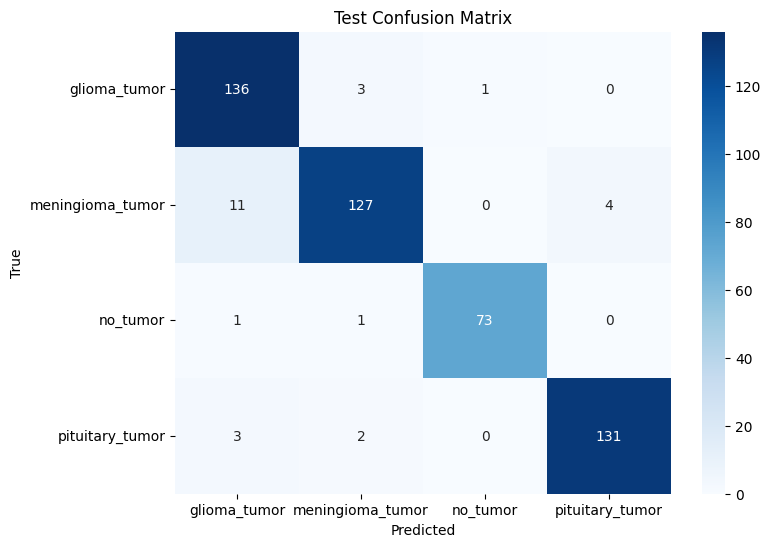


📊 Class-wise ROC AUC & PR AUC (Test):
              Class ROC AUC  PR AUC
0      glioma_tumor  0.9938  0.9895
1  meningioma_tumor  0.9889  0.9778
2          no_tumor  0.9998  0.9990
3   pituitary_tumor  0.9991  0.9978
Inference time: 1.21s | Per sample: 0.0025s | GPU Mem: 110.16MB | RAM: 2670.53MB

Cohen's Kappa: 0.9284
Brier Score (avg per class): 0.0216
Accuracy 95% CI: [0.9270,0.9655]
T-test class0 vs class1: stat=1.1462, p=0.2520
Mean PPV: 0.9531 | Mean NPV: 0.9820
Mean Specificity: 0.9817


In [ ]:
import os, time, psutil
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, brier_score_loss
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import timm
# ----------------------
# 0️⃣ Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# 1️⃣ Dataset & Loader
# ----------------------
batch_size = 32
train_dir = "/kaggle/working/brain_train_aug"
val_dir   = "/kaggle/working/brain_split/val"
test_dir  = "/kaggle/working/brain_split/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# ----------------------
# 2️⃣ MaxViT Model
# ----------------------
model = timm.create_model('tiny_vit_5m_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# ----------------------
# 3️⃣ Training Loop
# ----------------------
num_epochs = 35
best_val_loss = float('inf')
patience_counter = 0
train_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_maxvit.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered")
            break

train_time = time.time() - train_start_time
print(f"\n✅ Training complete. Total time: {train_time:.2f}s")

# ----------------------
# 4️⃣ Load best model
# ----------------------
model.load_state_dict(torch.load('best_maxvit.pth'))
model.eval()

# ----------------------
# 5️⃣ Prediction helper
# ----------------------
def get_preds(loader):
    labels_list, preds_list, probs_list = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
    return np.array(labels_list), np.array(preds_list), np.array(probs_list)

train_labels, train_preds, train_probs = get_preds(train_loader)
val_labels, val_preds, val_probs       = get_preds(val_loader)
test_labels, test_preds, test_probs    = get_preds(test_loader)
test_labels_onehot = np.eye(num_classes)[test_labels]

# ----------------------
# 6️⃣ Classification Reports
# ----------------------
print("\n📄 Train Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names, digits=4))
print("\n📄 Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))
print("\n📄 Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# ----------------------
# 7️⃣ Confusion Matrix
# ----------------------
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()

# ----------------------
# 8️⃣ ROC & PR AUC
# ----------------------
roc_auc_list = [roc_auc_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
pr_auc_list  = [average_precision_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
auc_df = pd.DataFrame({"Class": class_names, "ROC AUC": [f"{x:.4f}" for x in roc_auc_list],
                       "PR AUC": [f"{x:.4f}" for x in pr_auc_list]})
print("\n📊 Class-wise ROC AUC & PR AUC (Test):")
print(auc_df)

# ----------------------
# 9️⃣ Inference time & memory
# ----------------------
start_inf = time.time(); _ = get_preds(test_loader)
inf_time = time.time()-start_inf
inf_time_per_sample = inf_time / len(test_dataset)
mem_usage = torch.cuda.memory_allocated()/1024**2 if torch.cuda.is_available() else 0
ram_usage = psutil.virtual_memory().used/1024**2
print(f"Inference time: {inf_time:.2f}s | Per sample: {inf_time_per_sample:.4f}s | GPU Mem: {mem_usage:.2f}MB | RAM: {ram_usage:.2f}MB")

# ----------------------
# 🔟 Additional metrics
# ----------------------
kappa = cohen_kappa_score(test_labels, test_preds)
brier_list = [brier_score_loss(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
brier_avg = np.mean(brier_list)

# Bootstrap accuracy CI
n_samples = len(test_labels)
boot_acc = []
rng = np.random.default_rng()
for _ in range(1000):
    idx = rng.choice(n_samples, n_samples, replace=True)
    boot_acc.append(np.mean(test_labels[idx] == test_preds[idx]))
ci_low, ci_high = np.percentile(boot_acc, [2.5,97.5])

# Compute PPV, NPV, Specificity for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-8)
NPV = TN / (TN + FN + 1e-8)
specificity = TN / (TN + FP + 1e-8)

mean_ppv = np.mean(PPV)
mean_npv = np.mean(NPV)
mean_specificity = np.mean(specificity)

# T-test for the first two classes
ttest_res = ttest_ind(test_probs[:, 0], test_probs[:, 1])

# Print metrics
print(f"\nCohen's Kappa: {kappa:.4f}")
print(f"Brier Score (avg per class): {brier_avg:.4f}")
print(f"Accuracy 95% CI: [{ci_low:.4f},{ci_high:.4f}]")
print(f"T-test class0 vs class1: stat={ttest_res.statistic:.4f}, p={ttest_res.pvalue:.4f}")
print(f"Mean PPV: {mean_ppv:.4f} | Mean NPV: {mean_npv:.4f}")
print(f"Mean Specificity: {mean_specificity:.4f}")


In [ ]:

!pip install torchsummary

# =========================
# Imports
# =========================
import torch
import torch.optim as optim
from torchsummary import summary
import timm

# =========================
# Device Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# Model Setup (DeiT-Small)
# =========================
model = timm.create_model('tiny_vit_5m_224', pretrained=True, num_classes=5)
model.to(device)

# =========================
# Model Summary
# =========================
print("✅ TinyViT Model Summary\n")
summary(model, input_size=(3, 224, 224), device=str(device))

# =========================
# Count trainable & non-trainable params
# =========================
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total_params = trainable_params + non_trainable_params

print("\n================ Parameters Info ================")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {total_params:,}")

# =========================
# Optimizer Setup
# =========================
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

print("\n================ Optimizer Info ================")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Weight Decay: {optimizer.param_groups[0]['weight_decay']}")

# =========================
# Model Size (Approximate)
# =========================
import os
import torch
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024**2  # in MB (assuming 4 bytes per parameter)
print(f"\nModel size: {model_size:.2f} MB")


✅ TinyViT Model Summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              GELU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]          18,432
       BatchNorm2d-5           [-1, 64, 56, 56]             128
        PatchEmbed-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]          16,384
       BatchNorm2d-8          [-1, 256, 56, 56]             512
              GELU-9          [-1, 256, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]           2,304
      BatchNorm2d-11          [-1, 256, 56, 56]             512
             GELU-12          [-1, 256, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          16,384
      BatchNor